In [1]:
import pandas as pd
import os
import math
import requests
import re
from shapely.geometry import shape
import folium 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
tweets = pd.read_csv("./data/tweet_location_data_cleaned.csv")

In [3]:
tweets.head()

created_at  \
0  Wed Jan 20 23:59:58 +0000 2021   
1  Wed Jan 20 23:59:58 +0000 2021   
2  Wed Jan 20 23:59:57 +0000 2021   
3  Wed Jan 20 23:59:55 +0000 2021   
4  Wed Jan 20 23:59:55 +0000 2021   

                                                text user_location  \
0  WE DID IT JOE!! \nYOUâ€™RE gonnandjfndndhebehr...           NaN   
1  #JoeBiden : A better person, a better man, a b...           NaN   
2  Girl Crushing on #KamalaHarris while at the sa...           NaN   
3  Curious: how many #Trump supporters who canâ€™...   Brooklyn Ny   
4  @ZaidZamanHamid's account has been withheld in...           NaN   

       user_name  user_verified  \
0   Kay Brittany            0.0   
1        Rev. Al            0.0   
2    RAJIV KUMAR            0.0   
3        Yisroel            0.0   
4  Sohail Ashraf            0.0   

                                    user_description  \
0  SkinCare Products @kayscoffeescrub 23 years yo...   
1                           Poor but Happy Democrat.   
2  #Entrepreneur II Food Evangelist II Economist ...   
3  life enthusiast. wide eyed idealist. nerd wann...   
4                                                NaN   

                  user_created_at                   country iso2 iso3  \
0  Fri May 09 03:19:52 +0000 2014               No Location  NaN  NaN   
1  Sat Jul 28 19:35:49 +0000 2012               No Location  NaN  NaN   
2  Thu Feb 19 12:00:05 +0000 2009               No Location  NaN  NaN   
3  Thu Mar 24 02:44:03 +0000 2011  United States of America   NY  NYC   
4  Sat Jun 23 09:36:52 +0000 2012               No Location  NaN  NaN   

       city state  
0       NaN   Nan  
1       NaN   Nan  
2       NaN   Nan  
3  Brooklyn   NaN  
4       NaN   Nan

In [4]:
tweets['userid'] = pd.factorize(tweets['user_name'])[0]

### Converting to Date and Time Format

In [5]:
tweets["created_at"] = pd.to_datetime(tweets["created_at"], errors='coerce')
tweets["created_at"] = tweets["created_at"].dt.strftime('%Y-%m-%d %H:%M:%S')

tweets["user_created_at"] = pd.to_datetime(tweets["user_created_at"], errors='coerce')
tweets["user_created_at"] = tweets["user_created_at"].dt.strftime('%Y-%m-%d %H:%M:%S')

C:\Users\sincl\AppData\Local\Temp\ipykernel_14908\1557084992.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tweets["created_at"] = pd.to_datetime(tweets["created_at"], errors='coerce')
C:\Users\sincl\AppData\Local\Temp\ipykernel_14908\1557084992.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tweets["user_created_at"] = pd.to_datetime(tweets["user_created_at"], errors='coerce')


In [6]:
tweets.sample(2)

created_at                                               text  \
17486  2021-01-20 20:23:49  Our First National Youth Poet Laureate @TheAma...   
19110  2021-01-20 20:06:59  Biden to Inherit #Trumpâ€™s Aggressive #Iran S...   

       user_location         user_name  user_verified  \
17486  El Cerrito Ca  Carolyn Wysinger            0.0   
19110            NaN  Freedom For Iran            0.0   

                                        user_description      user_created_at  \
17486  Queer Author/Blogger, Board President of @sfpr...  2008-11-30 00:43:57   
19110  Here to educate the world about the terrorist ...  2016-10-14 18:35:16   

           country iso2 iso3        city state  userid  
17486       Canada   CA  CAN  El Cerrito   NaN   11940  
19110  No Location  NaN  NaN         NaN   Nan   15384

### Removing Special Characters 

In [7]:
tweets['text'] = tweets['text'].str.replace(r'[^\w\s]','',regex=True) 
tweets['text'] = tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
tweets['text'] = tweets['text'].str.title()
tweets['text'] = tweets['text'].str.strip()

In [8]:
tweets.sample(5)

created_at                                               text  \
26051  2021-01-20 19:05:21  Wow Helping The First Lady Get In That Preside...   
27153  2021-01-20 18:57:40  Its Done Nuclear Codes Are Again In The Hands ...   
37558  2021-01-20 17:53:25  This Brilliant Poet Laureate Added Such A Powe...   
16150  2021-01-20 20:38:38  Just Watching This Again  And To See Joebiden ...   
22189  2021-01-20 19:38:00  I Found Hunter  And Wow They Picked The Perfec...   

               user_location                        user_name  user_verified  \
26051              South Cal                    Jerry A. Wick            0.0   
27153  Wolfsburg Deutschland                           Markus            0.0   
37558           Manhattan Ny                   Heather Thomas            0.0   
16150        Indianapolis In                           Trisha            0.0   
22189                    NaN  Uncle Louie G's #dknarf @DKNARF            0.0   

                                        user_description      user_created_at  \
26051  8 & 24 forever, bleed purple & gold #Lakers 17...  2010-10-06 15:43:29   
27153  Informatiker, SÃ¤nger, PC-Spieler\n\n... und a...  2019-03-11 18:59:45   
37558  Avid fashionista, world traveller, creative, a...  2010-03-13 17:43:48   
16150                                                NaN  2011-05-21 15:46:34   
22189  starting over. NEW ACCOUNTðŸ¤¦ðŸ»â€â™‚ï¸ #m...  2014-03-13 11:26:55   

                        country iso2 iso3          city state  userid  
26051                    Turkey   TR  TUR           Çal   NaN   20639  
27153                   Germany   DE  DEU     Wolfsburg   NaN   21443  
37558  United States of America   NY  NYC     Manhattan   NaN   29231  
16150                     India   IN  IND  Indianapolis   NaN   13167  
22189               No Location  NaN  NaN           NaN   Nan     203

In [9]:
user_columns = ['userid', 'user_verified', 'user_description', 'user_created_at']  
user = tweets[user_columns]
# user.to_csv("./data/user.csv", index = False)

tweets_columns = ['userid','user_name','text', 'country','created_at']
tweets_info = tweets[tweets_columns]
# tweets_info.to_csv("./data/tweets.csv",  index = False)

country = ['userid','country', 'iso2','iso3','city','state']
country = tweets[country]
# country.to_csv("./data/country.csv",  index = False)

In [10]:
user

userid  user_verified  \
0           0            0.0   
1           1            0.0   
2           2            0.0   
3           3            0.0   
4           4            0.0   
...       ...            ...   
38954   30227            0.0   
38955   30228            0.0   
38956   30229            0.0   
38957   30230            0.0   
38958   30231            0.0   

                                        user_description      user_created_at  
0      SkinCare Products @kayscoffeescrub 23 years yo...  2014-05-09 03:19:52  
1                               Poor but Happy Democrat.  2012-07-28 19:35:49  
2      #Entrepreneur II Food Evangelist II Economist ...  2009-02-19 12:00:05  
3      life enthusiast. wide eyed idealist. nerd wann...  2011-03-24 02:44:03  
4                                                    NaN  2012-06-23 09:36:52  
...                                                  ...                  ...  
38954  Arizona desert dweller for 30+ years. Lover of...  2016-11-28 19:21:42  
38955  â€œNever be limited by others peopleâ€™s limit...  2019-01-22 21:43:13  
38956                                                NaN  2009-04-17 19:35:49  
38957  A conservative dude, Team #MCFC , retweet not ...  2011-11-25 17:47:10  
38958  Love to #design ! #TVBlogger -----------------...  2013-10-09 13:35:04  

[38959 rows x 4 columns]

In [11]:
tweets_info

userid               user_name  \
0           0            Kay Brittany   
1           1                 Rev. Al   
2           2             RAJIV KUMAR   
3           3                 Yisroel   
4           4           Sohail Ashraf   
...       ...                     ...   
38954   30227              Ron Lee AZ   
38955   30228                    Kris   
38956   30229                  JaneKC   
38957   30230                   ABOKI   
38958   30231  #M'Sass âœŒðŸ½âœŒðŸ»   

                                                    text  \
0      We Did It Joe \nYouâre Gonnandjfndndhebehrbeja...   
1      Joebiden  A Better Person A Better Man A Bette...   
2      Girl Crushing On Kamalaharris While At The Sam...   
3      Curious How Many Trump Supporters Who Canât St...   
4      Zaidzamanhamids Account Has Been Withheld In I...   
...                                                  ...   
38954  I Wonder If Scumbag Dems Are As Completely Ama...   
38955  New President Just Dropped\nInauguration Biden...   
38956  Knocked It Right Out Of The Park And Then Some...   
38957                    Twitter Is Boring Without Trump   
38958  Joebiden Being Sworn In Today As The 46Th Pres...   

                        country           created_at  
0                   No Location  2021-01-20 23:59:58  
1                   No Location  2021-01-20 23:59:58  
2                   No Location  2021-01-20 23:59:57  
3      United States of America  2021-01-20 23:59:55  
4                   No Location  2021-01-20 23:59:55  
...                         ...                  ...  
38954  United States of America  2021-01-20 17:47:49  
38955  United States of America  2021-01-20 17:47:48  
38956               No Location  2021-01-20 17:47:48  
38957                   Nigeria  2021-01-20 17:47:48  
38958                   Germany  2021-01-20 17:47:47  

[38959 rows x 5 columns]

In [12]:
country

userid                   country iso2 iso3      city    state
0           0               No Location  NaN  NaN       NaN      Nan
1           1               No Location  NaN  NaN       NaN      Nan
2           2               No Location  NaN  NaN       NaN      Nan
3           3  United States of America   NY  NYC  Brooklyn      NaN
4           4               No Location  NaN  NaN       NaN      Nan
...       ...                       ...  ...  ...       ...      ...
38954   30227  United States of America   US  USA       Usa  Arizona
38955   30228  United States of America   DC  USA     Miami      NaN
38956   30229               No Location  NaN  NaN       NaN      Nan
38957   30230                   Nigeria   NG  NGA       NaN      NaN
38958   30231                   Germany   DE  DEU       NaN      NaN

[38959 rows x 6 columns]

### Creating WordClouds

In [13]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

#### Wordcloud for All Countries

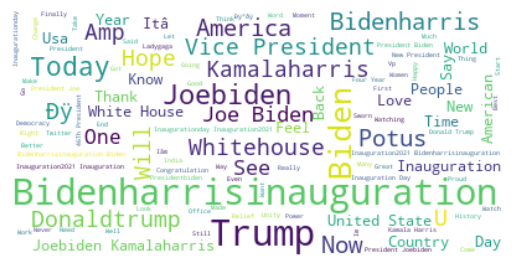

In [14]:
text = " ".join(review for review in tweets.text)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Wordcloud for Top Ten Countries

In [15]:
top_countries = tweets[tweets['country'] != 'No Location']
top_countries = top_countries['country'].value_counts()
top_country_list = top_countries.index.tolist()
top_country_list = list(top_country_list)[:10]
top_country_list

['United States of America',
 'United Kingdom',
 'Canada',
 'India',
 'Japan',
 'Turkey',
 'Nigeria',
 'Germany',
 'Pakistan',
 'Burkina Faso']

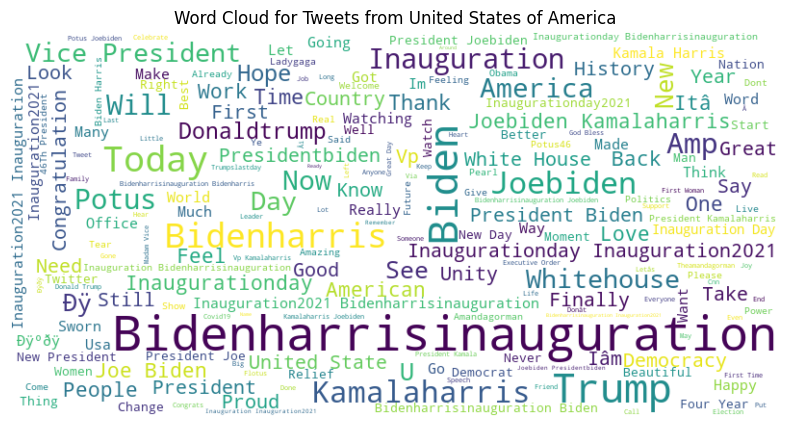

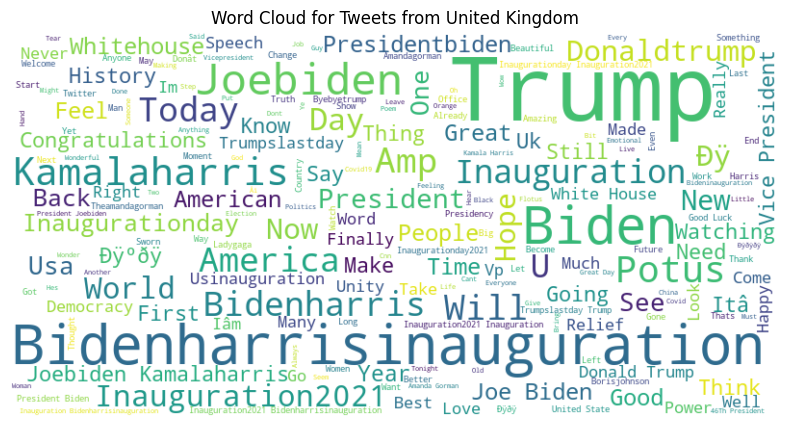

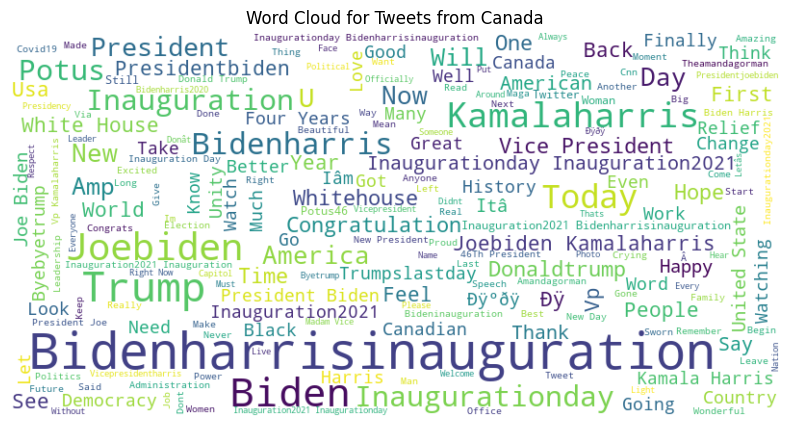

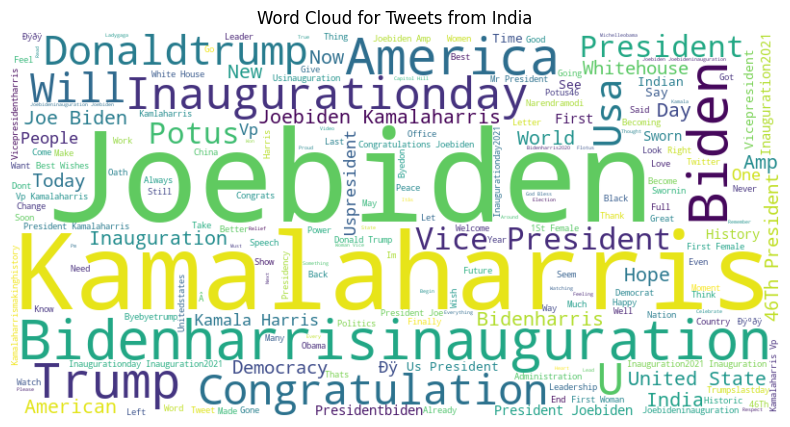

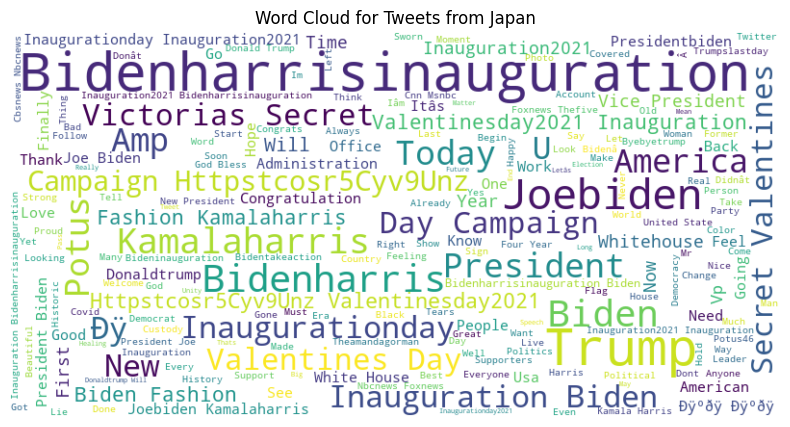

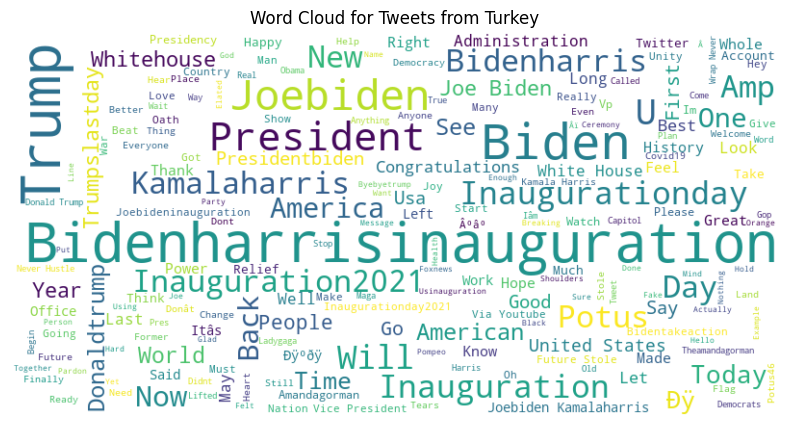

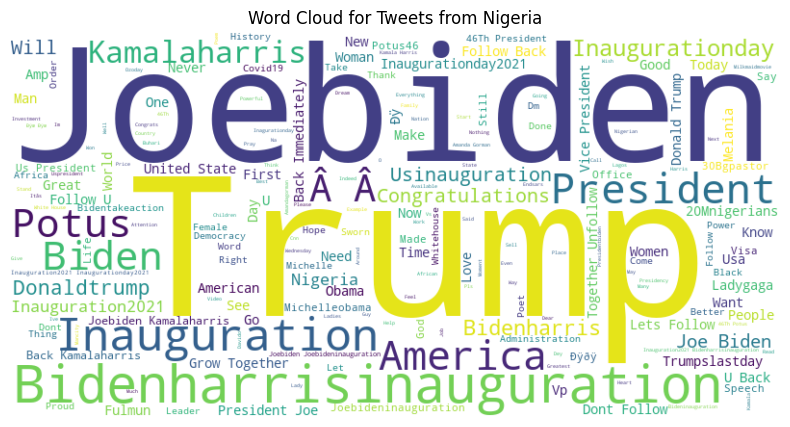

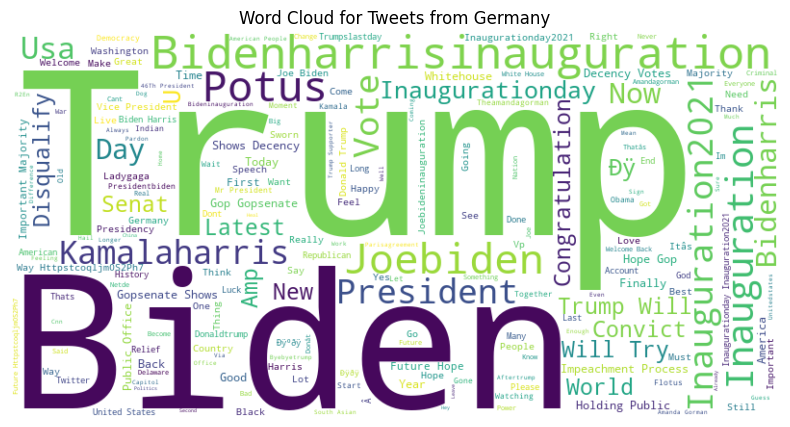

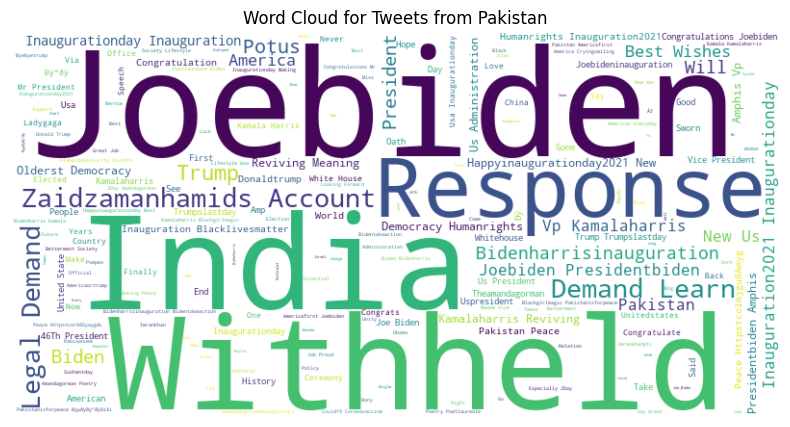

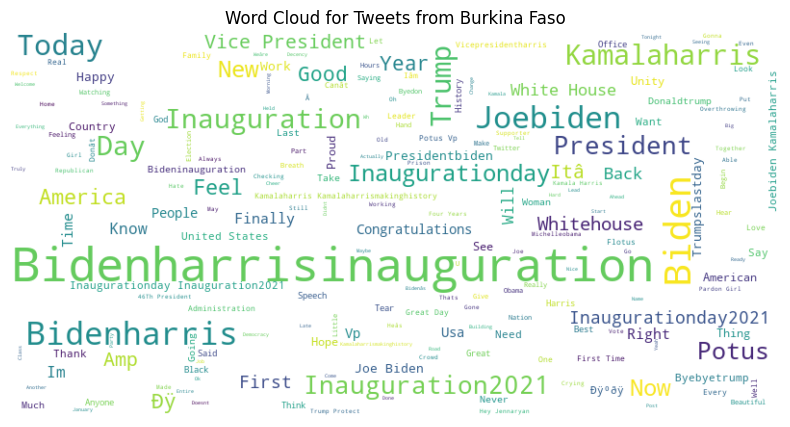

In [16]:
for country in top_country_list[:10]:  
    country_tweets = tweets[tweets['country'] == country]

    text = " ".join(review for review in country_tweets['text'] if isinstance(review, str))
    
    wordcloud = WordCloud(stopwords=stopwords,
                          background_color="white",
                          width=800,
                          height=400).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Tweets from {country}")
    plt.show()

In [17]:
country = tweets.groupby("country")
country.describe().head()

user_verified                                              userid  \
                    count      mean       std  min  25%  50%  75%  max  count   
country                                                                         
Afghanistan          10.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   10.0   
Albania              69.0  0.217391  0.415493  0.0  0.0  0.0  0.0  1.0   69.0   
Algeria               2.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0    2.0   
Andorra             153.0  0.045752  0.209632  0.0  0.0  0.0  0.0  1.0  153.0   
Anguilla              1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0    1.0   

                                                                             \
                     mean           std      min      25%      50%      75%   
country                                                                       
Afghanistan  17586.800000   7859.715485   1155.0  13280.0  18602.5  21773.0   
Albania      15724.391304   8693.613031    214.0   8366.0  16010.0  21151.0   
Algeria      15004.000000  14969.450558   4419.0   9711.5  15004.0  20296.5   
Andorra      14332.137255   9008.147183    363.0   5518.0  14398.0  21994.0   
Anguilla     29791.000000           NaN  29791.0  29791.0  29791.0  29791.0   

                      
                 max  
country               
Afghanistan  27256.0  
Albania      30199.0  
Algeria      25589.0  
Andorra      29623.0  
Anguilla     29791.0

### Top Ten Countries with the Highest Frequency of Tweets

In [18]:
top_countries = tweets[tweets['country'] != 'No Location']
top_countries = top_countries['country'].value_counts()
top_countries = pd.Series(top_countries)
top_countries

country
United States of America                         10998
United Kingdom                                    3325
Canada                                            1890
India                                             1451
Japan                                              940
                                                 ...  
Belize                                               1
Mauritania                                           1
French Polynesia                                     1
Monaco                                               1
Saint Helena, Ascension, and Tristan da Cunha        1
Name: count, Length: 179, dtype: int64

In [19]:
country_counts = top_countries.reset_index() 
country_counts.columns = ['country', 'count']
country_counts['count_log'] = np.log(country_counts['count'])
country_counts

country  count  count_log
0                         United States of America  10998   9.305469
1                                   United Kingdom   3325   8.109225
2                                           Canada   1890   7.544332
3                                            India   1451   7.280008
4                                            Japan    940   6.845880
..                                             ...    ...        ...
174                                         Belize      1   0.000000
175                                     Mauritania      1   0.000000
176                               French Polynesia      1   0.000000
177                                         Monaco      1   0.000000
178  Saint Helena, Ascension, and Tristan da Cunha      1   0.000000

[179 rows x 3 columns]

Text(0, 0.5, 'Number of Tweets')

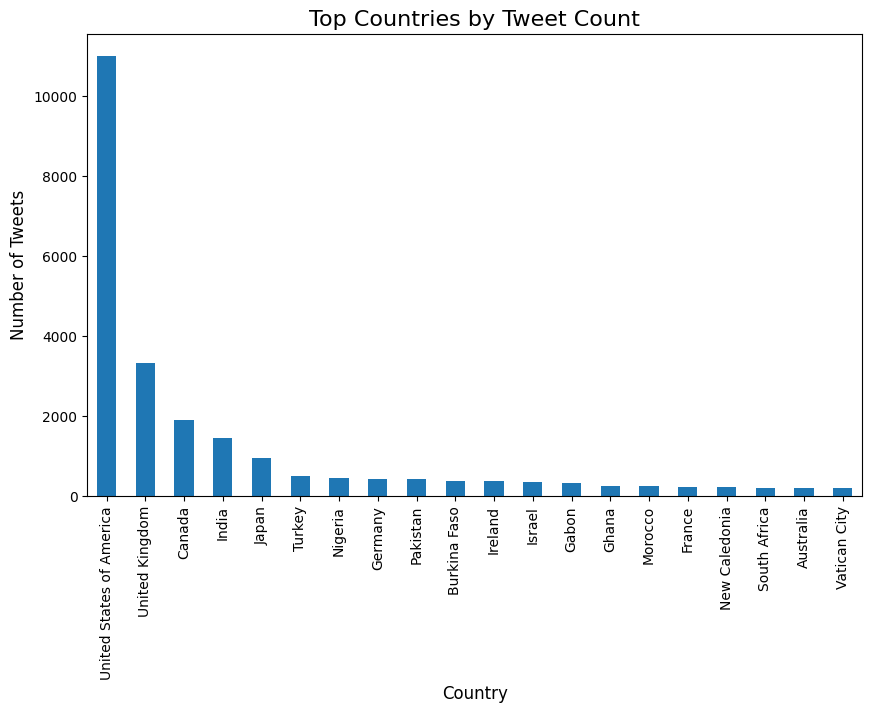

In [20]:
top_countries_20 = top_countries.head(20)
plt.figure(figsize=(10, 6))
top_countries_20.plot(kind='bar')
plt.title('Top Countries by Tweet Count', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

### World Map Showing the Distibution of Tweets

In [21]:
m = folium.Map(location = [0,0], zoom_start = 2, zoom_control=False ,scrollWheelZoom=False, dragging=False)

geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
response = requests.get(geojson_url)
geojson = response.json()

In [22]:
folium.Choropleth(
    geo_data=geojson,
    data=country_counts,
    fill_color="Greens",
    columns=['country', 'count_log'],
    key_on='feature.properties.name',
    fill_opacity=0.8,
    line_opacity=0.4,
    legend_name="Tweet Locations Frequency"
).add_to(m)

In [23]:
count_dict = dict(zip(country_counts['country'], country_counts['count']))

In [24]:
geojson_layer = folium.GeoJson(
    geojson,
    name="Country Info",
    style_function=lambda x: {
        'fillOpacity': 0,
        'color': 'black',
        'weight': 0.1
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['name', 'count'],
        aliases=['Country:', 'Tweet Count:'],
        localize=True,
        sticky=True,
        labels=True
    )
).add_to(m)

In [25]:
for feature in geojson['features']:
    country_name = feature['properties']['name']
    feature['properties']['count'] = count_dict.get(country_name, 0)
    count = count_dict.get(country_name, 0)
    geom = shape(feature['geometry'])
    lon, lat = geom.centroid.coords[0]
    
    folium.Marker(
        location=[lat, lon],
        icon=folium.DivIcon(html=f"<div style='font-size: 7pt; color: black;'>{count}</div>")
    ).add_to(m)

In [26]:
m